In [1]:
from lbmpy.session import *
from pystencils.timeloop import TimeLoop
from pystencils import Target

# Tutorial 07: Coupling two LBM simulations for thermal simulations

In this notebook we demonstrate how to run a thermal lattice Boltzmann simulation.
We use a separate set of distribution functions to solve the advection-diffusion equation for the temperature.
The zeroth moment of these additional pdfs corresponds to temperature. 

The thermal LB step is coupled to the normal hydrodynamic LB scheme using the Boussinesq approximation. The force on the liquid is proportional to the relative temperature. The hydrodynamic LB method computes the fluid velocity which in turn enters the thermal scheme, completing the two-way coupling.

To set this up in *lbmpy* we create first a `data handling` object and create an array to store the temperature.

In [2]:
domain_size = (50, 50, 50)

target = ps.Target.CPU
dh = ps.create_data_handling(domain_size, default_target=target)
temperature_field = dh.add_array("T", values_per_cell=1)
dh.fill('T', val=0.0)

Next, we define how to compute the local force from the temperature field:

In [3]:
force = sp.Matrix([0, temperature_field.center * 3e-4, 0])

Now, we can create both LB steps. 

The coupling is created by passing the following parameters to the hydrodynamic step,

- `compute_velocity_in_every_step`: usually the velocity is not computed/stored in every time step, only for output and plotting reasons. In the coupled algorithm we have to make sure that after every time step the current velocity is stored in an array, since it enters the thermal LB scheme.
- `force`: we can simply pass our sympy expression for the force here, as long as the `LatticeBoltzmannStep` operates on a data handling that stores the fields that are referenced in the expression. This is why we have to create the data handling first and pass it to both Step objects

and to the thermal step
- `compute_density_in_every_step`: density corresponds to the temperature here, which we need to be computed in every time step, since it enters the force expression for the hydrodynamic scheme
- `velocity_input_array_name`: the velocity entering the thermal equilibrium equation is not computed as first moment of the thermal pdfs. Instead, the hydrodynamic velocity is used here.

For the hydrodynamic lattice Boltzmann step, we use a D3Q19 stencil, while we use a D3Q7 stencil to solve the thermal lattice Boltzmann step.

In [4]:
config = ps.CreateKernelConfig(target=target, cpu_openmp=True)

target = ps.Target.CPU
dh = ps.create_data_handling(domain_size, default_target=target)
temperature_field = dh.add_array("T", values_per_cell=1)
dh.fill('T', val=0.0)

hydro_step   = LatticeBoltzmannStep(data_handling=dh, name='hydro', stencil=LBStencil(Stencil.D3Q19),
                                    relaxation_rate=1.8,
                                    compute_velocity_in_every_step=True,
                                    force=force, config=config)
thermal_step = LatticeBoltzmannStep(data_handling=dh, name='thermal', stencil=LBStencil(Stencil.D3Q7),
                                    relaxation_rate=1.3, density_data_name="T",
                                    compute_density_in_every_step=True,
                                    compressible=True,
                                    velocity_input_array_name=hydro_step.velocity_data_name,
                                    config=config)

We add `NoSlip` boundary conditions on all all walls for both schemes with the exception of the left and right wall of the thermal scheme. Here we set a heated and a cooled wall, where the temperature is fixed to `0.5` and `-0.5`. This kind of Dirichlet boundary condition can be set using a `FixedDensity` LB boundary.

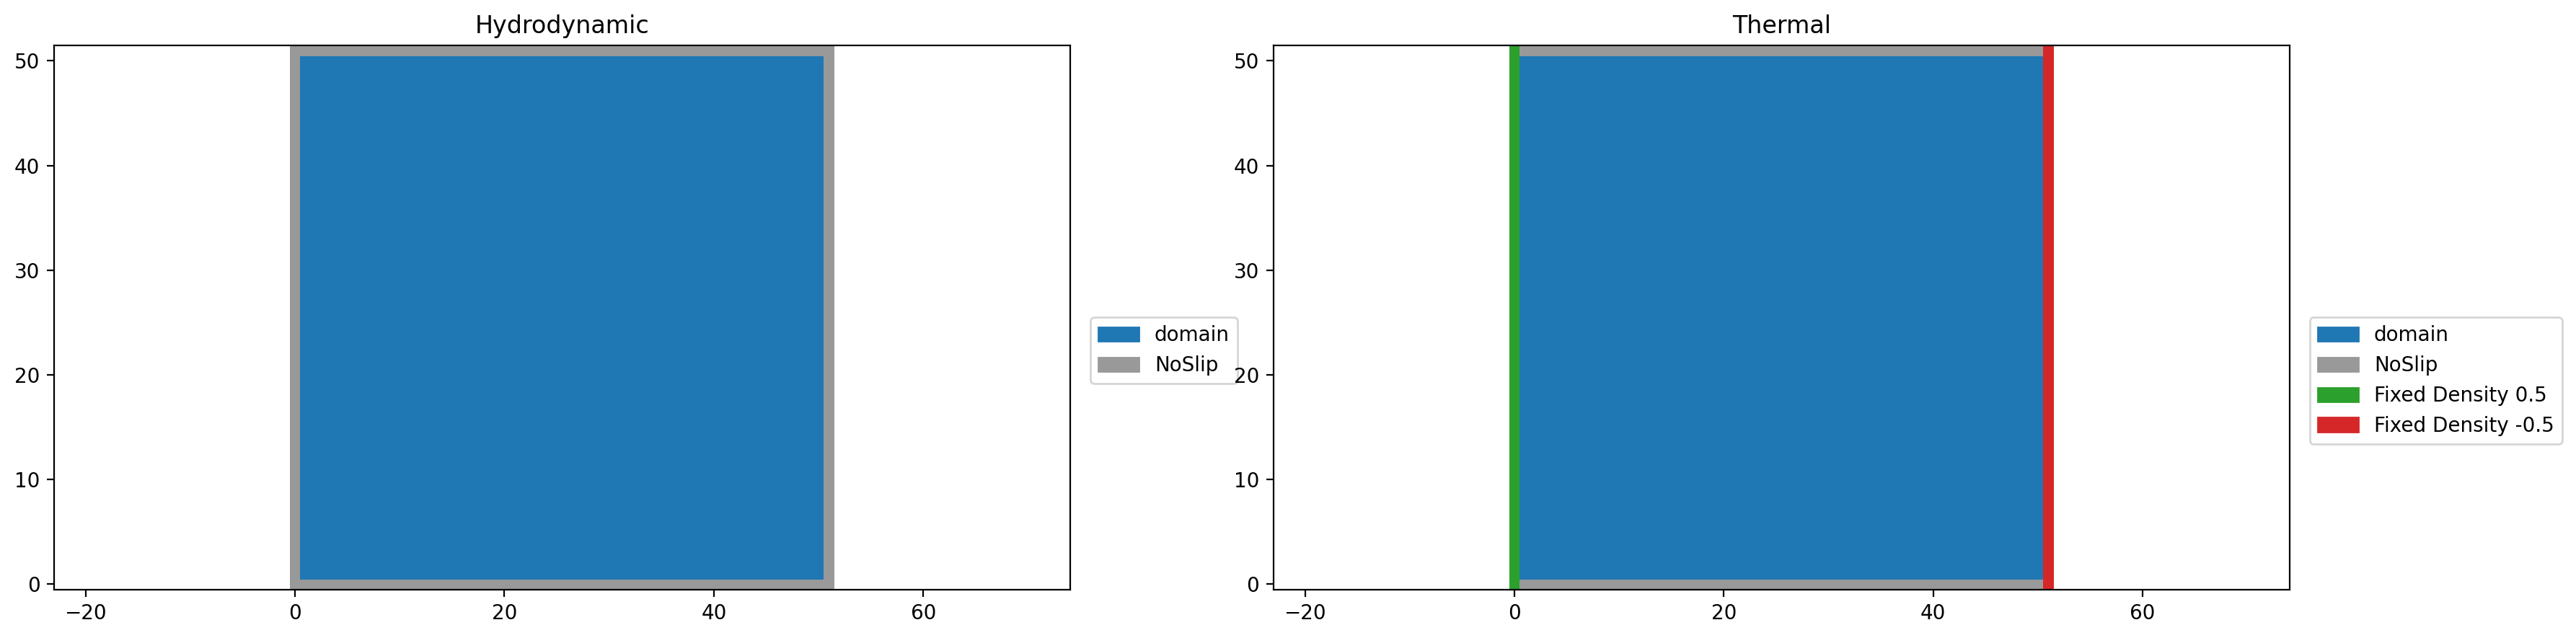

In [5]:
add_box_boundary(hydro_step.boundary_handling)
add_box_boundary(thermal_step.boundary_handling)
thermal_step.boundary_handling.set_boundary(FixedDensity(0.5), slice_from_direction('W', dh.dim))
thermal_step.boundary_handling.set_boundary(FixedDensity(-0.5), slice_from_direction('E', dh.dim))

plt.figure(figsize=(20, 5), dpi=200)
plt.subplot(1, 2, 1)
plt.title("Hydrodynamic")
plt.boundary_handling(hydro_step.boundary_handling, make_slice[:, :, domain_size[2] // 2])
plt.subplot(1, 2, 2)
plt.title("Thermal")
plt.boundary_handling(thermal_step.boundary_handling, make_slice[:, :, domain_size[2] // 2])

In [6]:
def run(time_steps):
    hydro_step.pre_run()
    thermal_step.pre_run()
    for t in range(time_steps):
        hydro_step.time_step()
        thermal_step.time_step()
    hydro_step.post_run()
    thermal_step.post_run()
    hydro_step.time_steps_run += time_steps
    thermal_step.time_steps_run += time_steps

In [7]:
if 'is_test_run' not in globals():
    run(5000)
else:
    run(10)

assert np.isfinite(hydro_step.velocity[:, :, :].max())
assert np.isfinite(thermal_step.density[:, :, :].max())

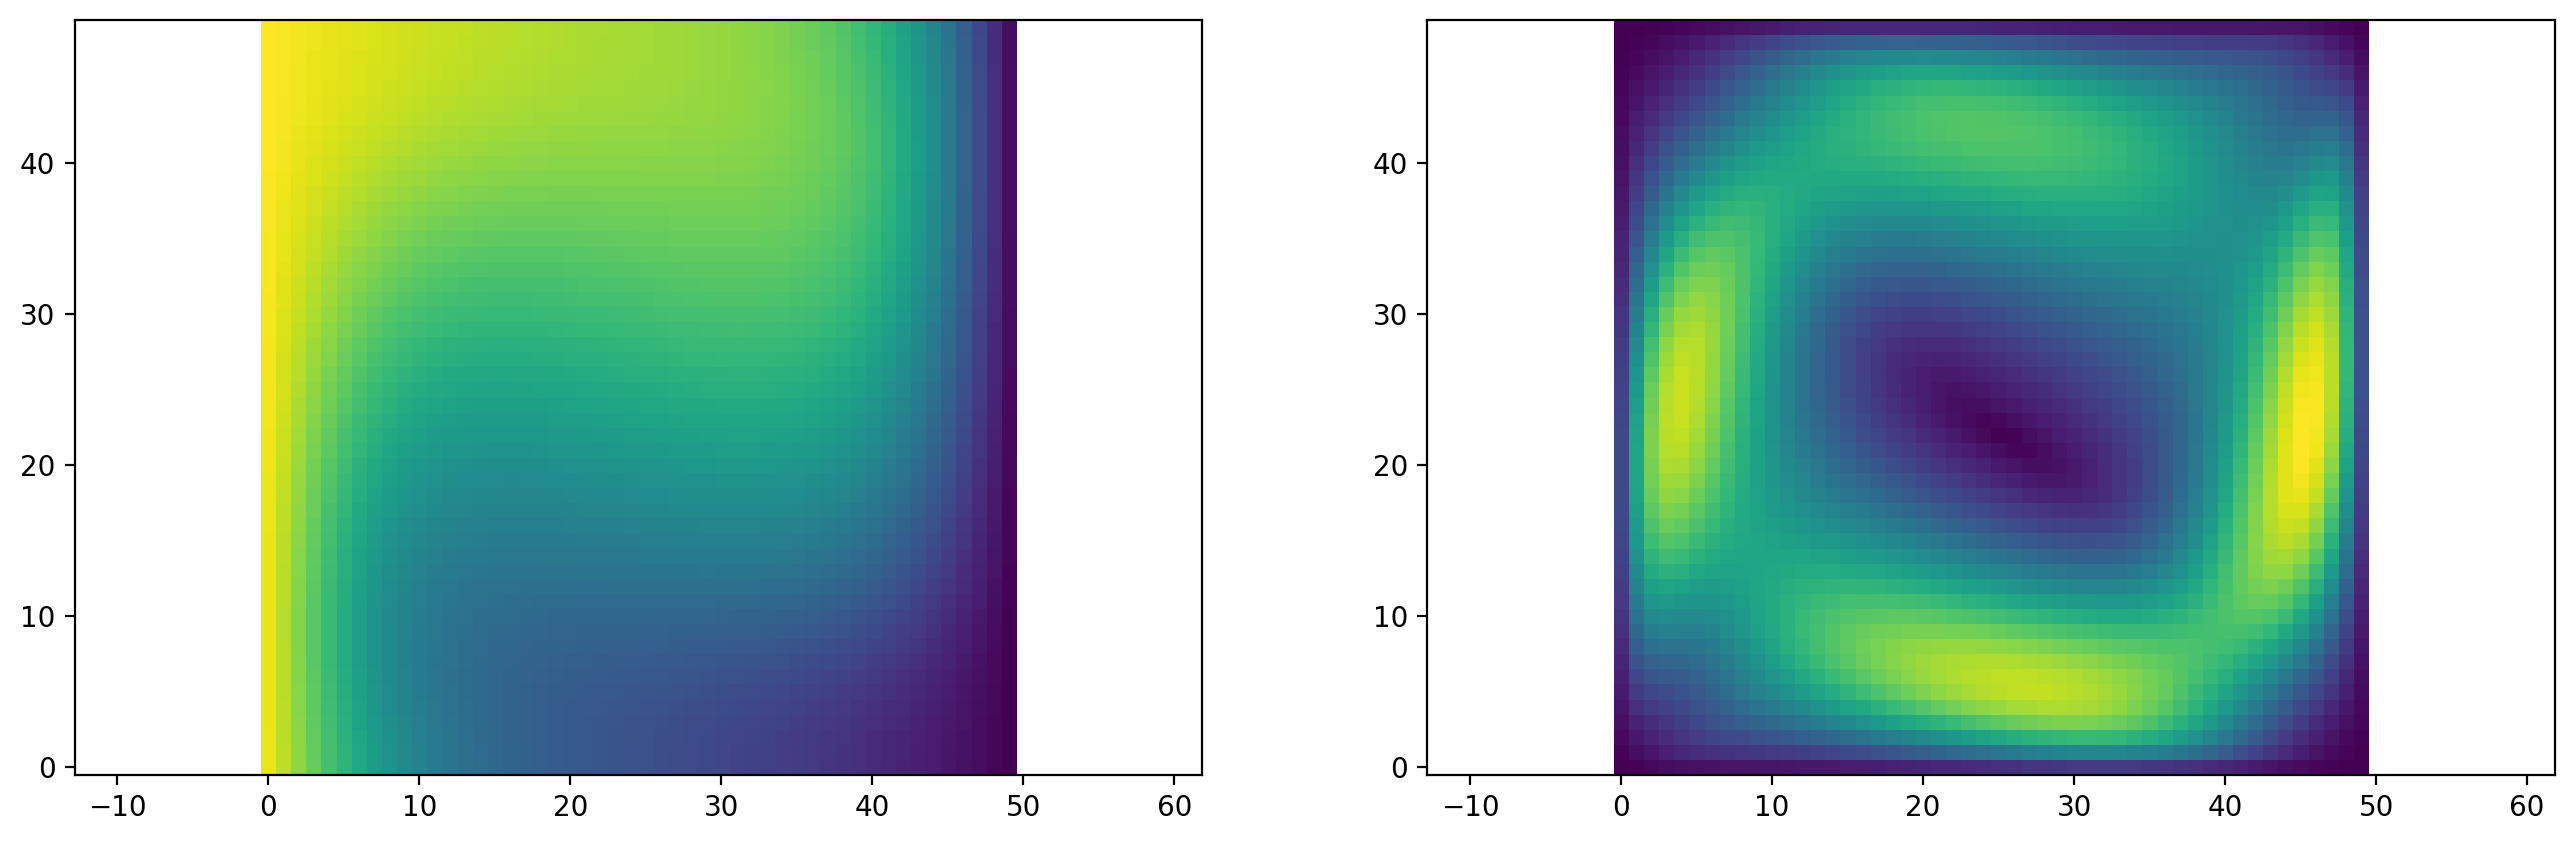

In [8]:
plt.figure(figsize=(16, 5), dpi=200)
plt.subplot(1, 2, 1)
plt.scalar_field(thermal_step.density[:, :, domain_size[2] // 2])
plt.subplot(1, 2, 2)
plt.vector_field_magnitude(hydro_step.velocity[:, :, domain_size[2] // 2])

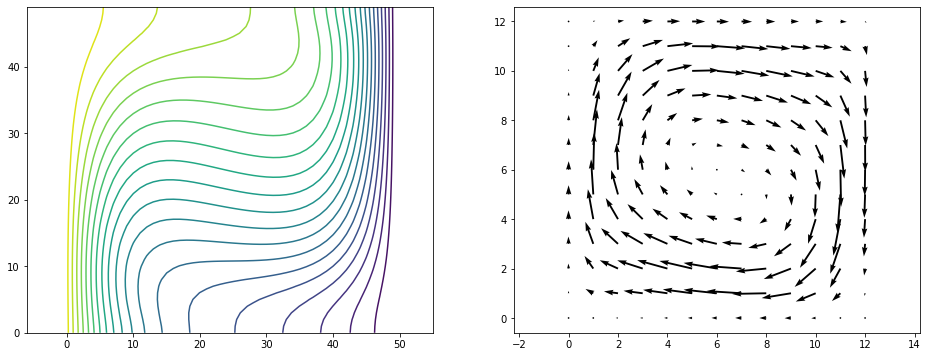

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].axis('equal')
axs[0].contour(np.transpose(thermal_step.density[:, :, domain_size[2] // 2]), 21, origin=None)

qq = hydro_step.velocity[:, :, domain_size[2] // 2]
axs[1].axis('equal')
axs[1].quiver(np.transpose(qq[0:50:4, 0:50:4, 0]), np.transpose(qq[0:50:4, 0:50:4, 1]))